<a href="https://colab.research.google.com/github/AriannaHeartbell/sd-llm_example/blob/main/diffusers_sdxl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.패키지와 마운트

In [2]:
# パッケージのインストール
!pip install diffusers transformers omegaconf accelerate peft compel asdff Pillow piexif safetensors

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. 모델 준비와 파이프라인

In [3]:
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler
import torch

model = "yodayo-ai/kivotos-xl-2.0"

pipe = DiffusionPipeline.from_pretrained(
    model,
    torch_dtype=torch.float16,
    use_safetensors=True)

pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

# cpuモード
# pipe.enable_model_cpu_offload()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.30.0",
  "_name_or_path": "yodayo-ai/kivotos-xl-2.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# 3. Lora 준비

In [4]:
# LoRAウェイトの読み込み
pipe.load_lora_weights(".", weight_name="/content/drive/MyDrive/SD/models/Lora/yuina_kivotos-02.safetensors", adapter_name="yuina")
#pipe.load_lora_weights(".", weight_name="/content/drive/MyDrive/SD/models/Lora/Smooth Anime 2 Style SDXL_LoRA_Pony Diffusion V6 XL.safetensors", adapter_name="smooth")

In [5]:
pipe.set_adapters(["yuina"], adapter_weights=[1.0])

# 4. 프롬프트 준비

In [6]:
directory = "images"
directory2 = "/content/exif_images" #아래 exif와 이미지 저장 경로
key_file_path = "/content/drive/MyDrive/SD/diffusers_code/key/key.txt"  #key 저장경로

In [7]:
from compel import Compel, ReturnedEmbeddingsType
compel = Compel(tokenizer=[pipe.tokenizer, pipe.tokenizer_2] , text_encoder=[pipe.text_encoder, pipe.text_encoder_2], returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED, requires_pooled=[False, True], truncate_long_prompts=False)

### 아래 5. 이미지 생성 전 반드시 아래 프롬프르, 네거 프롬프트 cell들을 재 이용

In [58]:
prompt = "1girl, shirakawa yuina, heaven burns red, yuina headgear, platinum blonde hair, breasts cleavage, huge breasts, collarbone, white camisole, bare arms, black jeans, navel, looking at viewer, leaning forward, crossed legs, sleeveless, in park"
conditioning, pooled = compel.build_conditioning_tensor(prompt)

In [59]:
negative_prompt = "(low quality, worst quality:1.2, hair intakes, halo, pointy ears, elf), very displeasing, 3d, watermark, signature, ugly, poorly drawn, multiple girls, 2girls, 3d, realistic, headless, yuina capelet, monochrome, mature female, blurry, blurry background, earring"
negative_conditioning, _ = compel.build_conditioning_tensor(negative_prompt)
[conditioning_padded, negative_conditioning_padded] = compel.pad_conditioning_tensors_to_same_length([conditioning, negative_conditioning])
#[conditioning, negative_conditioning] = compel.pad_conditioning_tensors_to_same_length([conditioning, negative_conditioning])

In [10]:
from cryptography.fernet import Fernet
from PIL import Image
import piexif
import base64
import os
import shutil


# Fernet 키 생성 및 파일에 저장
def generate_and_save_key(key_file_path):
    key = Fernet.generate_key()
    with open(key_file_path, "w") as key_file:
        key_file.write(key.decode())  # base64 인코딩된 키를 문자열로 저장

# 문자열을 암호화하고 이미지의 EXIF에 저장하는 함수
def encrypt_string_and_add_to_exif(image_path, output_path, string_to_encrypt, key_file_path):
    # 키 파일에서 키를 불러옴
    with open(key_file_path, "r") as key_file:
        key = key_file.read().encode()  # 문자열을 다시 바이트로 인코딩
    cipher_suite = Fernet(key)

    # 문자열 암호화
    encrypted_string = cipher_suite.encrypt(string_to_encrypt.encode())

    # 이미지 로드
    img = Image.open(image_path)
    # EXIF 데이터가 있는지 확인하고, 없으면 초기화
    if 'exif' in img.info:
        exif_dict = piexif.load(img.info['exif'])
    else:
        exif_dict = {'0th': {}, 'Exif': {}, 'GPS': {}, '1st': {}, 'Interop': {}, 'thumbnail': None}

    # 'Exif' 섹션이 있는지 확인하고, 없으면 추가
    if 'Exif' not in exif_dict:
        exif_dict['Exif'] = {}

    # 암호화된 문자열을 UserComment에 추가
    exif_dict['Exif'][piexif.ExifIFD.UserComment] = encrypted_string
    exif_bytes = piexif.dump(exif_dict)

    # 이미지에 암호화된 EXIF 데이터 저장
    img.save(output_path, exif=exif_bytes)

# 사용 예
image_path = ""
output_path = ""
string_to_encrypt = prompt + "negative" + negative_prompt

# 키 생성 및 저장

if not os.path.exists(key_file_path):
    generate_and_save_key(key_file_path)
    print("새로운 키가 생성되어 저장되었습니다.")
else:
    print("기존의 키를 사용합니다.")

# 문자열 암호화 및 EXIF에 저장
#encrypt_string_and_add_to_exif(image_path, output_path, string_to_encrypt, key_file_path)


기존의 키를 사용합니다.


# 5. 이미지 생성

  0%|          | 0/27 [00:00<?, ?it/s]

7754

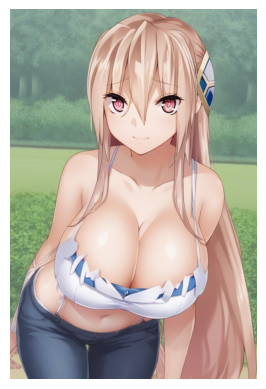

In [60]:
import matplotlib.pyplot as plt
import datetime
import os
import gc

if not os.path.exists(directory):
    os.makedirs(directory)
if not os.path.exists(directory2):
    os.makedirs(directory2)

# デフォルトサイズ(1024x1024)
image = pipe(
    prompt_embeds=conditioning_padded,
    negative_embeds=negative_conditioning_padded,
    pooled_prompt_embeds=pooled,
    guidance_scale=3,
    num_inference_steps=27,
    height=1344,
    width=896
    ).images[0]

# 현재 날짜와 시간을 기반으로 파일 이름 생성
filename = datetime.datetime.now().strftime('%Y%m%d%H%M%S%f') + ".png"

# 이미지를 저장할 경로
save_path = "images/" + filename
save_exif_path = directory2 + "/" + filename

# code runn
image.save(save_path) #이미지 저장
plt.imshow(image)
plt.axis('off')

string_to_encrypt = prompt + " / negative : " + negative_prompt #exif 준비
encrypt_string_and_add_to_exif(save_path, save_exif_path, string_to_encrypt, key_file_path) #암호화 하여 이미지에 exif 저장

# 이미지 생성 또는 메모리 집약적 작업 후
del conditioning, pooled, negative_conditioning, conditioning_padded, negative_conditioning_padded, image
prompt_embeds = None  # 텐서 객체 참조 해제
negative_embeds = None
pooled_prompt_embeds = None
gc.collect()  # 가비지 컬렉션 실행

# 6. Adetailer를 적용해 얼굴 수정

In [12]:
!git clone https://github.com/theblackhatmagician/adetailer_sdxl.git
%cd adetailer_sdxl

Cloning into 'adetailer_sdxl'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 16 (delta 2), reused 11 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 3.10 MiB | 42.92 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/adetailer_sdxl


In [13]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch==2.0.0+cu118 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0)
ERROR: No matching distribution found for torch==2.0.0+cu118


Inpainting...

0: 640x448 1 face, 10.8ms
Speed: 2.8ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)
padded dim: (261, 175, 704, 598)
Loading StableDiffusionXLInpaintPipeline


  0%|          | 0/8 [00:00<?, ?it/s]

generated inpaint dim: (1024, 1024)


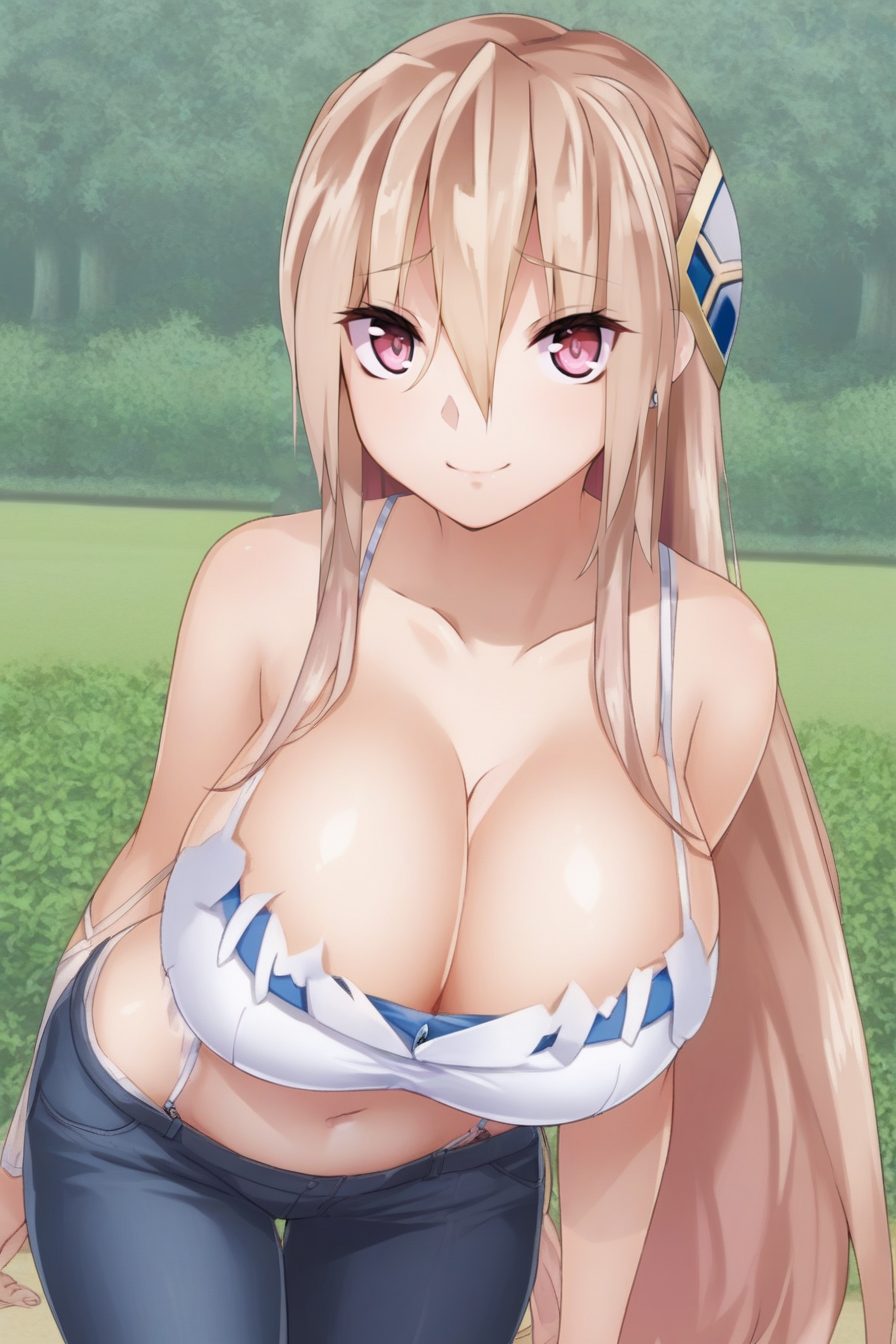

In [61]:

import torch
import random
from asdff.base import AdPipelineBase
from huggingface_hub import hf_hub_download
from diffusers import StableDiffusionXLPipeline
import os
from PIL import Image


face_prompt = "denoise, looking at viewer"
face_n_prompt = "source_pony, source_furry, bad eyes, noise, looking away, sharp face, mature woman, lips, lipstick, closed eyes"
guidance_scale = 3
num_images = 1
face_mask_pad = 8
mask_blur = 4
mask_dilation = 2
strength = 0.3
ddim_steps = 27

seed = random.randint(0, 3774)
generator = torch.manual_seed(seed)
model_path = "/root/.cache/huggingface/hub/models--yodayo-ai--kivotos-xl-2.0"
fixed_save_directory = '/content/adetailer_sdxl/fixed_images'

# 경로가 존재하지 않으면 폴더 생성
if not os.path.exists(fixed_save_directory):
    os.makedirs(fixed_save_directory)


# 이미지들이 저장된 디렉토리 경로
exif_image_directory = '/content/exif_images'

# 디렉토리 내 파일들 중 가장 최근에 생성된 파일 찾기
latest_file = max([os.path.join(exif_image_directory, f) for f in os.listdir(exif_image_directory)], key=os.path.getctime)

# 최근 파일을 ad_images로 열기
ad_images = Image.open(latest_file)

ad_components = pipe.components
ad_pipe = AdPipelineBase(**ad_components)

model_path = hf_hub_download("Bingsu/adetailer", "face_yolov8n.pt",local_dir = "asdff/yolo_models", local_dir_use_symlinks = False)
common = {"prompt": face_prompt,"n_prompt" : face_n_prompt, "num_inference_steps": int(ddim_steps), "target_size" : (1024,1024)}
inpaint_only = {'strength': strength}
# Inpainting 처리 부분
result = ad_pipe(common=common, inpaint_only=inpaint_only, images=ad_images, mask_dilation=mask_dilation, mask_blur=mask_blur, mask_padding=face_mask_pad, model_path=model_path)

# 원래 파일 이름에서 확장자를 제외한 이름과 확장자를 분리
original_filename = os.path.basename(latest_file)
filename_without_ext, file_extension = os.path.splitext(original_filename)

# "fix"를 추가한 새로운 파일 이름 생성
new_filename = f"{filename_without_ext}_fix{file_extension}"
fixed_save_path = os.path.join(fixed_save_directory, new_filename)

# 결과 이미지 저장
if result.images:
    result.images[0].save(fixed_save_path)
    display(result.images[0])

### A디테일러 관련 경로 확인

In [23]:
import os

# 현재 작업 디렉토리 확인
print(os.getcwd())


/content/adetailer_sdxl


In [17]:
from huggingface_hub import hf_hub_download

# 이 코드를 사용하면 모델 파일 경로를 확인할 수 있어요
model_path = hf_hub_download(repo_id=model, filename="model_index.json")
print(f"Model downloaded to: {model_path}")

Model downloaded to: /root/.cache/huggingface/hub/models--yodayo-ai--kivotos-xl-2.0/snapshots/b2ea1b45c1f10d5e40f497accf8b484b0a7e0c93/model_index.json


### 이미지에 저장된 eixf 복호화

In [ ]:
decrypting_image_path = "/content/exif_images/20240219171328704092.png"

# 저장된 키를 불러오는 함수
def load_key(key_file_path):
    with open(key_file_path, "r") as key_file:
        key = key_file.read().encode()  # 문자열을 다시 바이트로 인코딩
    return key

# 이미지의 EXIF 데이터로부터 암호화된 문자열을 추출하고 복호화하는 함수
def decrypt_string_from_exif(image_path, key):
    # Fernet 인스턴스 생성
    cipher_suite = Fernet(key)

    # 이미지 로드 및 EXIF 데이터 추출
    img = Image.open(image_path)
    exif_dict = piexif.load(img.info['exif'])

    # 암호화된 문자열(UserComment) 추출
    if piexif.ExifIFD.UserComment in exif_dict['Exif']:
        encrypted_string = exif_dict['Exif'][piexif.ExifIFD.UserComment]

        # 복호화
        decrypted_string = cipher_suite.decrypt(encrypted_string).decode('utf-8')
        print("복호화된 문자열:", decrypted_string)
    else:
        print("해당 이미지에는 암호화된 문자열이 없습니다.")

# 키 불러오기
key = load_key(key_file_path)

# 암호화된 문자열 복호화 및 출력
decrypt_string_from_exif(decrypting_image_path, key)


복호화된 문자열: score_9, score_8_up, score_7_up, 1girl, solo close-up, hbryuina, n yuina, yuina hair ornament, cute round face, aged down, platinum blonde hair, rua-chan makeup:0.4, perfect proportion, bare shoulders, collarbone, pink eyes, eyelashes, makeup, nude, navel, pubic hair, pussy, large breasts, wide pelvis, looking at viewer, in room, seductive pose, arched back, dynamic angle, shiny skin, toned:0.3 / negative : 3d, hyperrealistic, source_furry, censored, furry, rua-chan, source_comic, monochrome, rua-chan hair, rua-chan hairstyle, alternate hairstyle, short hair, black hair, blue hair, alternate hair color, forehead, hair intakes, out of frame, head out of frame, sharp eyes, lip, lipstick, arms up, arm up, abs, holding


In [ ]:
#reference

#1 https://note.com/npaka/n/n1170de1604f3
#2 https://github.com/damian0815/compel#compel
#3 https://github.com/theblackhatmagician/adetailer_sdxl